In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [31]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("store.csv")

In [32]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


In [33]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [34]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [35]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26 00:00:00
End Date:  2015-01-30 00:00:00


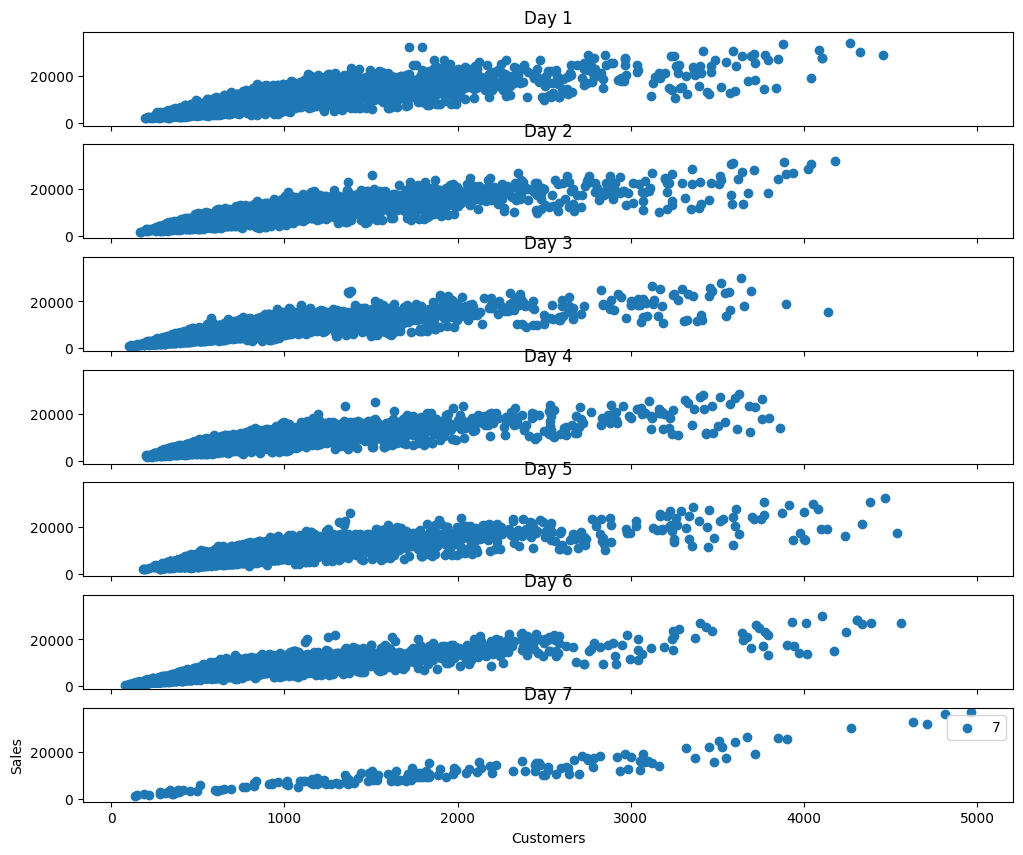

In [36]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_4128\97535340.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))


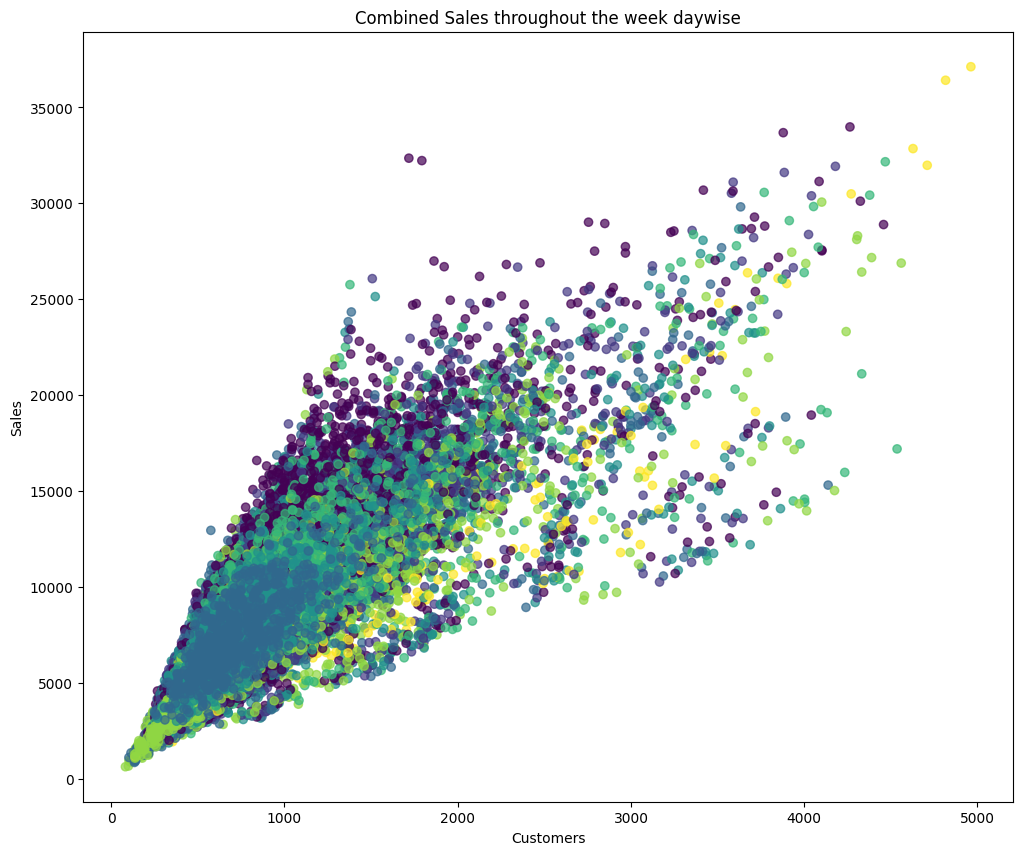

In [37]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))
plt.title('Combined Sales throughout the week daywise')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

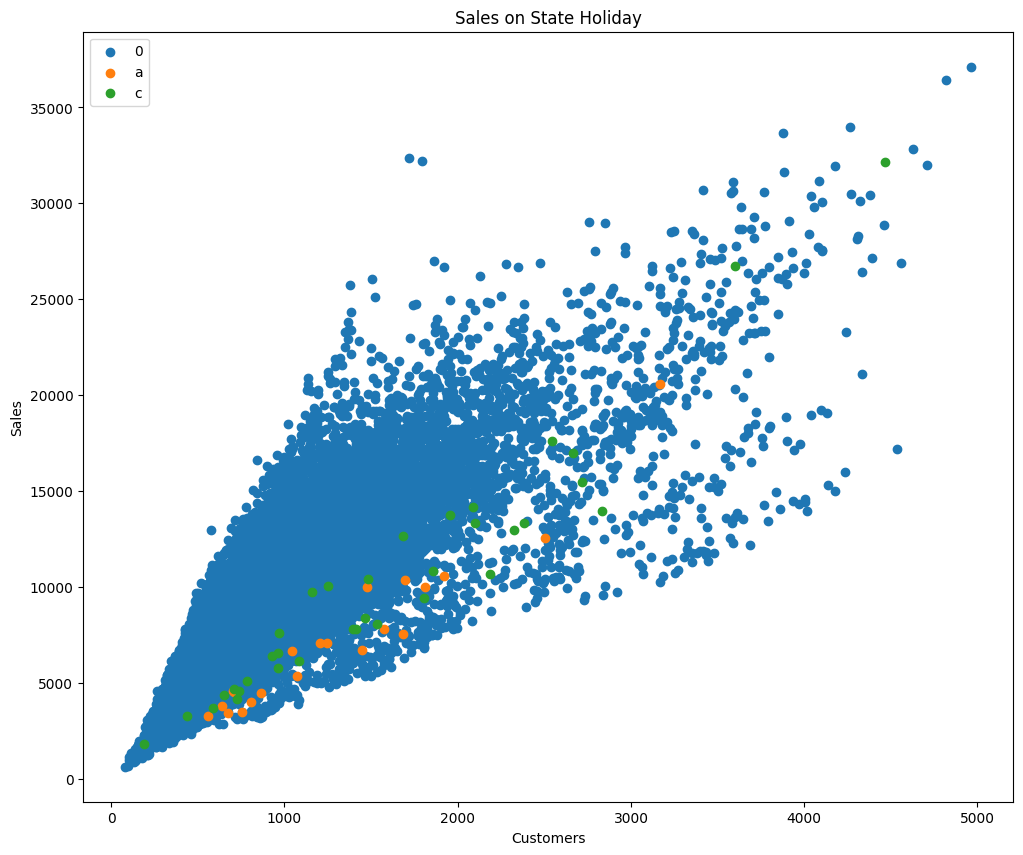

In [38]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.title('Sales on State Holiday')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

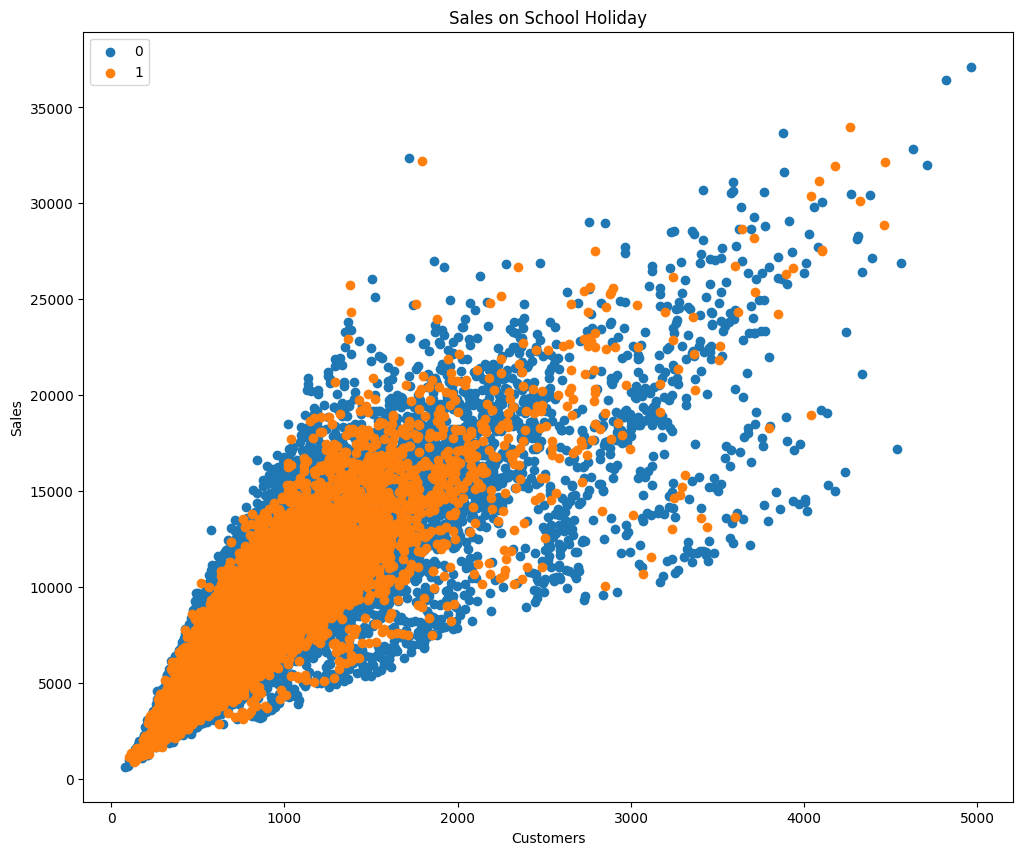

In [39]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.title('Sales on School Holiday')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

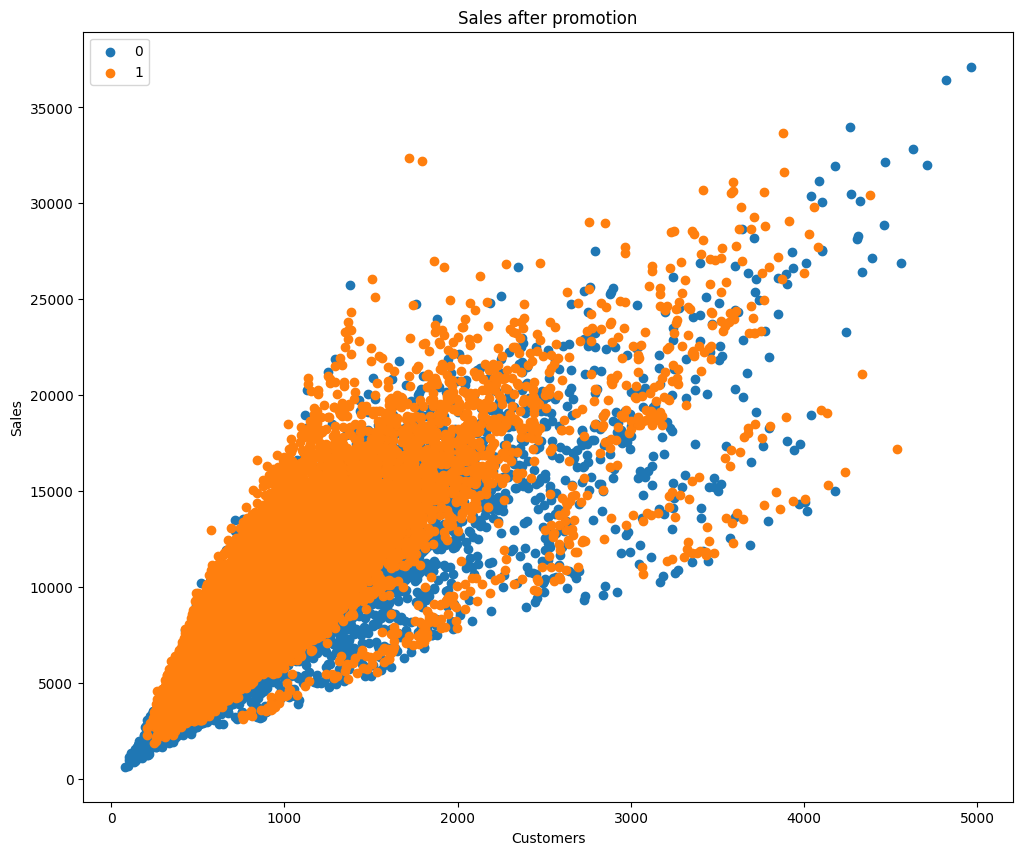

In [40]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.title('Sales after promotion')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [41]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5574.037037,644.407407,8.574182,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5593.407407,602.833333,9.132443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7560.740741,797.296296,9.363221,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,10730.296296,1424.888889,7.481731,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5313.981481,564.833333,9.273212,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


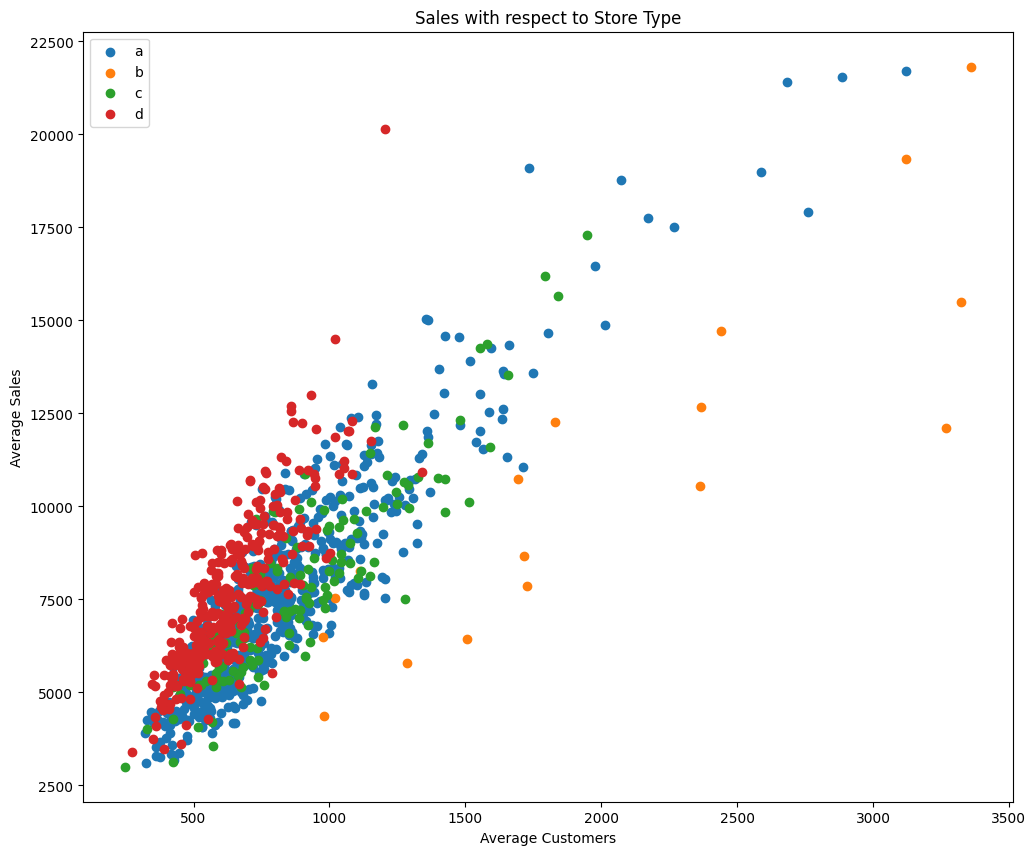

In [42]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.title('Sales with respect to Store Type')
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

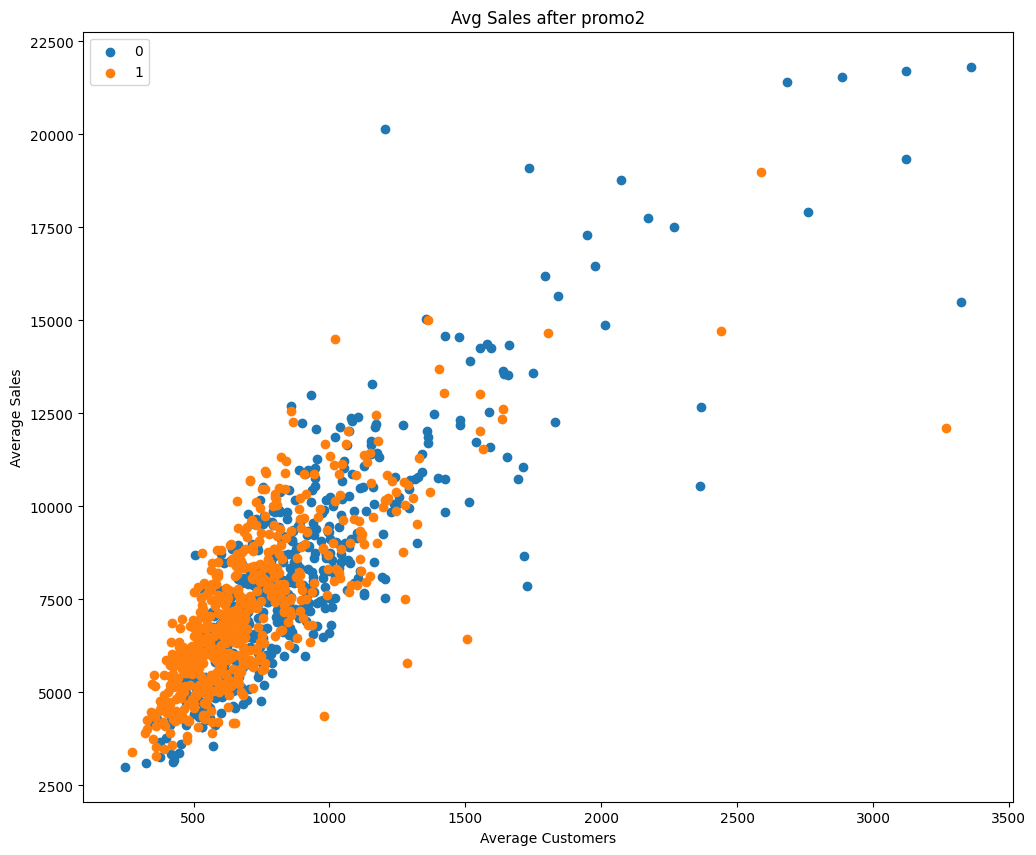

In [43]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.title('Avg Sales after promo2')
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

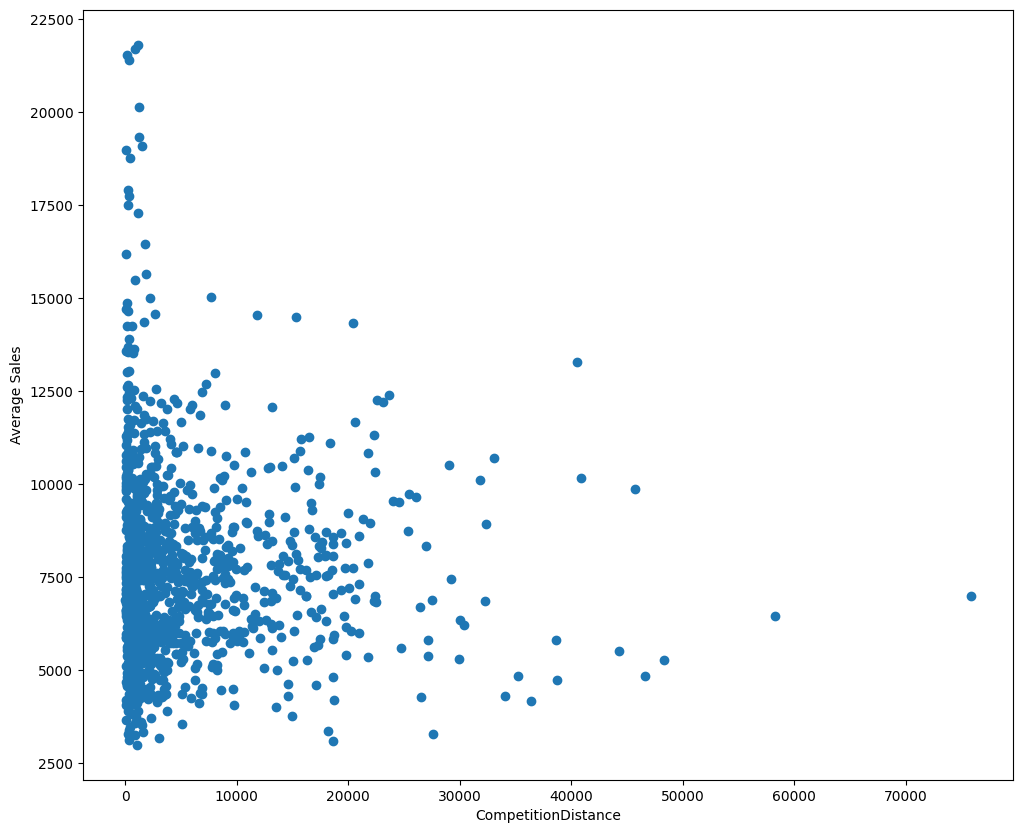

In [44]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [45]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')

    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)

    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.isocalendar().week

    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace


    merged['WeeksPromoOpen'] = \
    12 * (merged['Year'] - merged['Promo2SinceYear']) + \
    (merged['Date'].dt.isocalendar().week - merged['Promo2SinceWeek'])


    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'MonthsCompetitionOpen',
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-01-30,5577,616,1,1,0,0,9.053571,...,0,0,0,0,2015,1,30,5,76,24185
1,2,5,2015-01-30,5919,624,1,1,0,0,9.485577,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,1,30,5,86,52
2,3,5,2015-01-30,6911,678,1,1,0,0,10.193215,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,1,30,5,97,39
3,4,5,2015-01-30,13307,1632,1,1,0,0,8.153799,...,0,0,0,0,2015,1,30,5,64,24185
4,5,5,2015-01-30,5640,617,1,1,0,0,9.141005,...,0,0,0,0,2015,1,30,5,-3,24185


In [46]:
from sklearn.model_selection import train_test_split
X = [
    'Store',
    'Customers',
    'CompetitionDistance',

    'Promo',
    'Promo2',

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',

    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def rmspe(y, y_hat):
    return abs(np.sqrt(np.mean(((y - y_hat) / y) ** 2)))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', abs(score.mean()))
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)

    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)
    

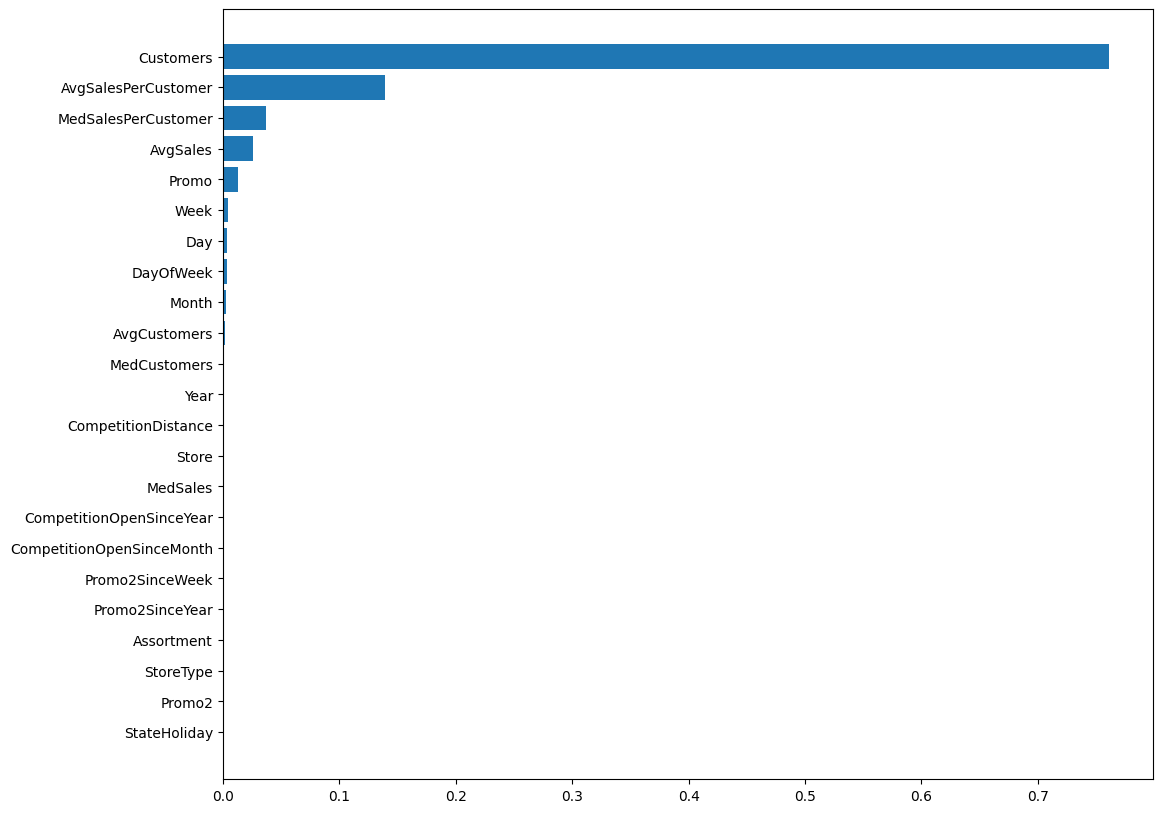

In [48]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

In [49]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

Mean 0.08491103783271313
Variance 6.598763561264153e-07
RMSPE 0.08299672788699805


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.2s finished


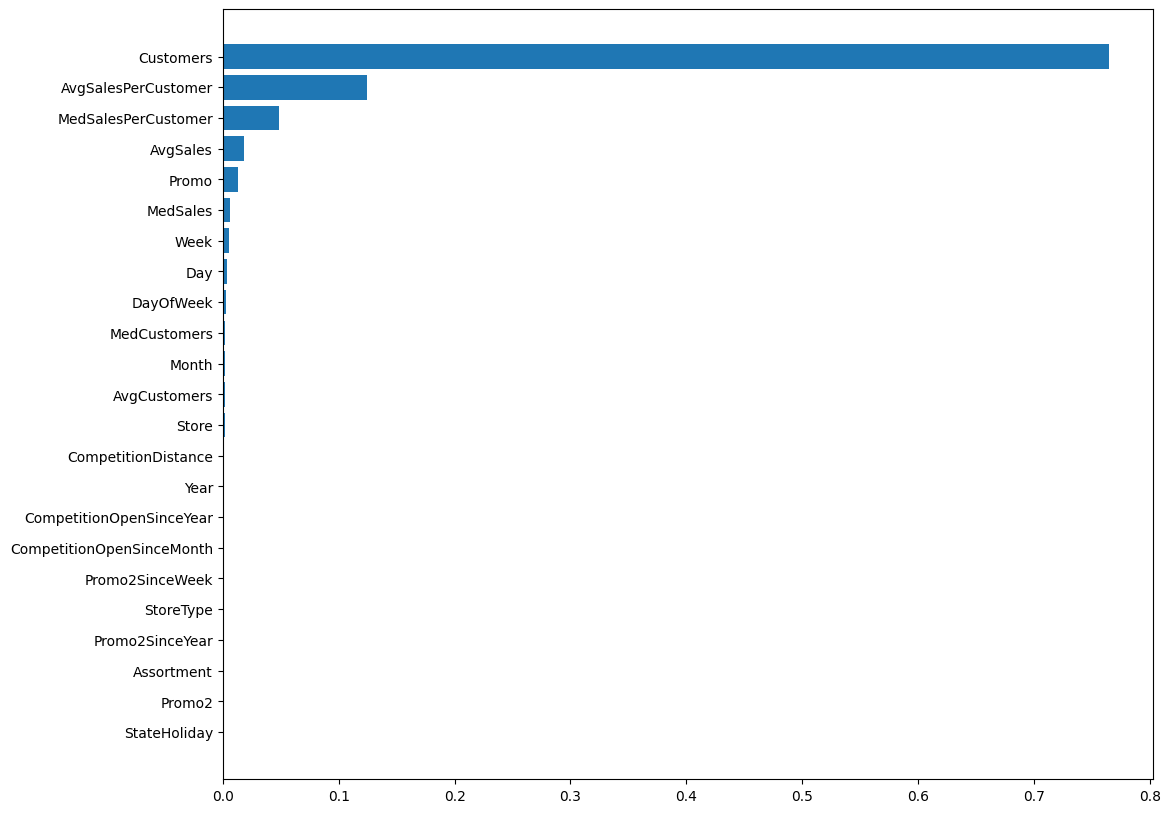

In [50]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

In [51]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jo

Mean 0.06072384588723688
Variance 6.101030339294024e-07
RMSPE 0.05967986297332242


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished


In [52]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train),
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

[0]	validation_0-rmse:0.41146	validation_0-rmspe:0.51108	validation_1-rmse:0.40459	validation_1-rmspe:0.49327
[1]	validation_0-rmse:0.38643	validation_0-rmspe:0.46964	validation_1-rmse:0.38019	validation_1-rmspe:0.45369
[2]	validation_0-rmse:0.36440	validation_0-rmspe:0.43771	validation_1-rmse:0.35846	validation_1-rmspe:0.42282
[3]	validation_0-rmse:0.34491	validation_0-rmspe:0.40562	validation_1-rmse:0.33945	validation_1-rmspe:0.39214
[4]	validation_0-rmse:0.32776	validation_0-rmspe:0.38298	validation_1-rmse:0.32238	validation_1-rmspe:0.37000
[5]	validation_0-rmse:0.31201	validation_0-rmspe:0.36134	validation_1-rmse:0.30695	validation_1-rmspe:0.34919
[6]	validation_0-rmse:0.29814	validation_0-rmspe:0.34183	validation_1-rmse:0.29350	validation_1-rmspe:0.33034


c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-rmse:0.28591	validation_0-rmspe:0.32303	validation_1-rmse:0.28128	validation_1-rmspe:0.31213
[8]	validation_0-rmse:0.27457	validation_0-rmspe:0.30769	validation_1-rmse:0.27028	validation_1-rmspe:0.29749
[9]	validation_0-rmse:0.26444	validation_0-rmspe:0.29630	validation_1-rmse:0.26016	validation_1-rmspe:0.28643
[10]	validation_0-rmse:0.25503	validation_0-rmspe:0.28074	validation_1-rmse:0.25116	validation_1-rmspe:0.27183
[11]	validation_0-rmse:0.24638	validation_0-rmspe:0.27031	validation_1-rmse:0.24267	validation_1-rmspe:0.26170
[12]	validation_0-rmse:0.23730	validation_0-rmspe:0.26055	validation_1-rmse:0.23348	validation_1-rmspe:0.25198
[13]	validation_0-rmse:0.22946	validation_0-rmspe:0.25144	validation_1-rmse:0.22579	validation_1-rmspe:0.24316
[14]	validation_0-rmse:0.22243	validation_0-rmspe:0.24047	validation_1-rmse:0.21913	validation_1-rmspe:0.23317
[15]	validation_0-rmse:0.21590	validation_0-rmspe:0.23230	validation_1-rmse:0.21294	validation_1-rmspe:0.22544
[16]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

Note that this is not in percentage, thus not to scale of graphs above


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

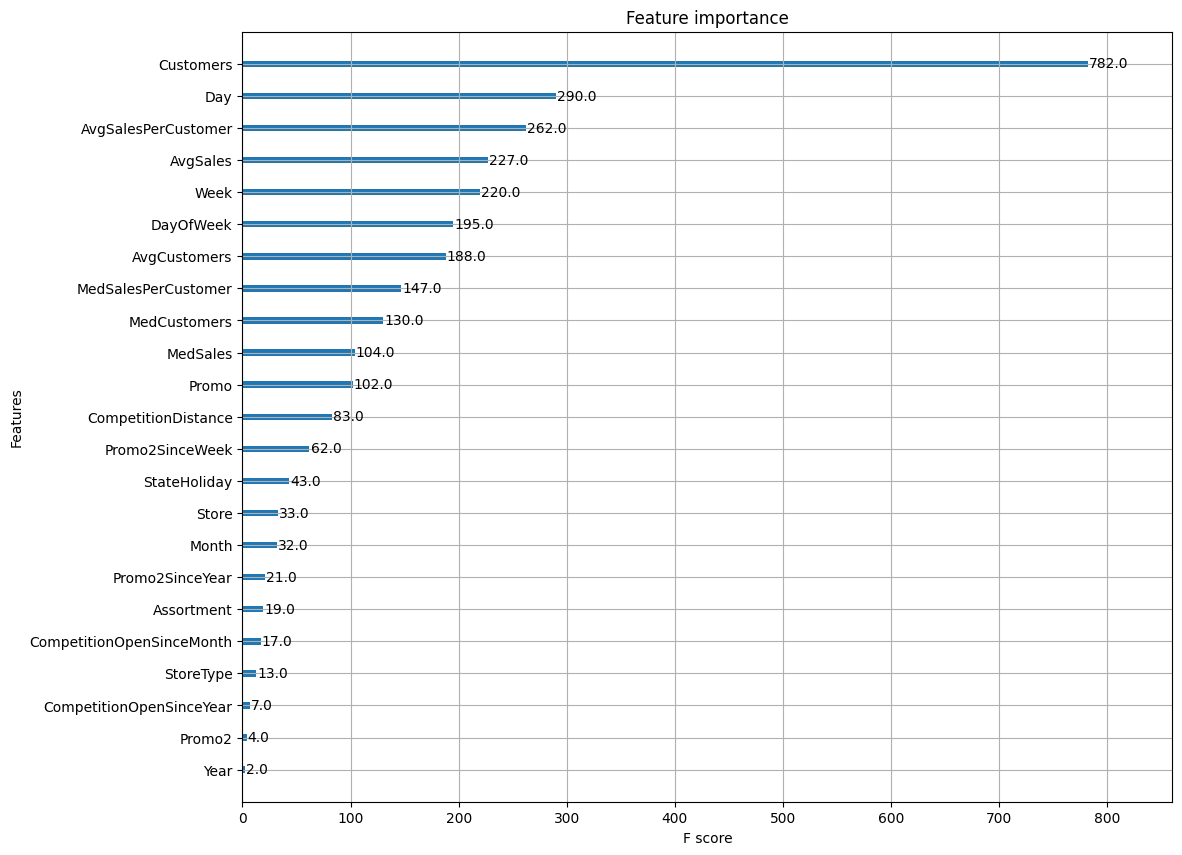

In [53]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [54]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', abs(score.mean()))
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))
   

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg,

Mean 0.05527399756181465
Variance 2.1195917600129122e-07
RMSPE 0.054297836525485525


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_j

Decision Tree:
Mean RMSPE: 0.0851031775425928
R2 Score: 0.962361599600743

Random Forest:
Mean RMSPE: 0.06084326399775826
R2 Score: 0.980793661769543

XGBoost:
Mean RMSPE: 0.059217758108770835
R2 Score: 0.9831096504954233


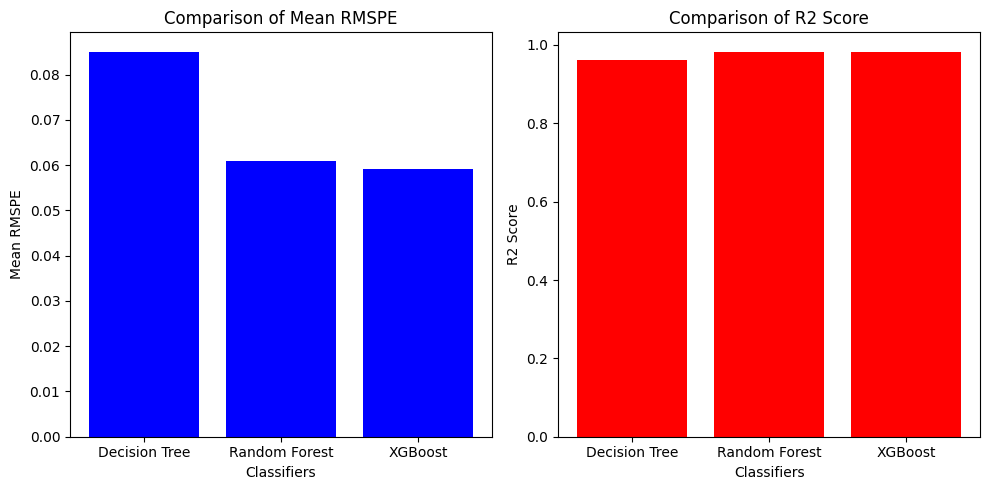

In [55]:
from sklearn.metrics import r2_score
# Define a function to calculate both RMSPE and R2 score
def calculate_scores(model, X_train, y_train, X_test, y_test):
    # Calculate RMSPE
    scores_rmspe = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    mean_rmspe = abs(scores_rmspe.mean())

    # Calculate R2 score
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = abs(r2_score(y_test, y_pred))

    return mean_rmspe, r2

# Calculate scores for Decision Tree
decision_tree_rmspe, decision_tree_r2 = calculate_scores(decision_tree, X_train, y_train, X_test, y_test)

# Calculate scores for Random Forest
random_forest_rmspe, random_forest_r2 = calculate_scores(randomForest, X_train, y_train, X_test, y_test)

# Calculate scores for XGBoost
xgboost_rmspe, xgboost_r2 = calculate_scores(xgboost_tree, X_train, y_train, X_test, y_test)

# Print out the scores
print("Decision Tree:")
print("Mean RMSPE:", decision_tree_rmspe)
print("R2 Score:", decision_tree_r2)

print("\nRandom Forest:")
print("Mean RMSPE:", random_forest_rmspe)
print("R2 Score:", random_forest_r2)

print("\nXGBoost:")
print("Mean RMSPE:", xgboost_rmspe)
print("R2 Score:", xgboost_r2)

# Visualize comparison of accuracies
import matplotlib.pyplot as plt

classifiers = ['Decision Tree', 'Random Forest', 'XGBoost']
rmspe_scores = [decision_tree_rmspe, random_forest_rmspe, xgboost_rmspe]
r2_scores = [decision_tree_r2, random_forest_r2, xgboost_r2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(classifiers, rmspe_scores, color='b')
plt.xlabel('Classifiers')
plt.ylabel('Mean RMSPE')
plt.title('Comparison of Mean RMSPE')

plt.subplot(1, 2, 2)
plt.bar(classifiers, r2_scores, color='r')
plt.xlabel('Classifiers')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Score')

plt.tight_layout()
plt.show()


In [56]:
test = pd.read_csv("test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('salesoutput.csv', index=False)

C:\Users\harsh\AppData\Local\Temp\ipykernel_4128\418222476.py:4: RuntimeWarning: overflow encountered in expm1
  y_hat = np.expm1(xgboost_tree.predict(features[X]))
